In [91]:
reset -fs

In [92]:
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob as tb
from autocorrect import spell

In [93]:
review_fn = "data/yelp_academic_dataset_review.json"
with open(review_fn, 'r', encoding='UTF-8') as f:
    rev_data = f.readlines()
    rev_data = list(map(json.loads, rev_data))
    
rev_df = pd.DataFrame(rev_data)

In [94]:
business_fn = 'data/yelp_academic_dataset_business.json'

with open(business_fn, 'r', encoding='UTF-8') as f:
    bus_data = f.readlines()
    bus_data = list(map(json.loads, bus_data))

bus_df = pd.DataFrame(bus_data)[
    ['business_id', 'categories', 'city', 'name', 'review_count', 'stars']]

In [95]:
bus_df = bus_df[bus_df.categories.str.contains('Restaurant|Food', na=False)]

rest_df = rev_df.merge(bus_df, how='inner', left_on='business_id',
                       right_on='business_id', suffixes=('_rev', '_rest'))

count    1.073841e+06
mean     3.742384e+00
std      1.208344e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.057000e+03
Name: review_id, dtype: float64


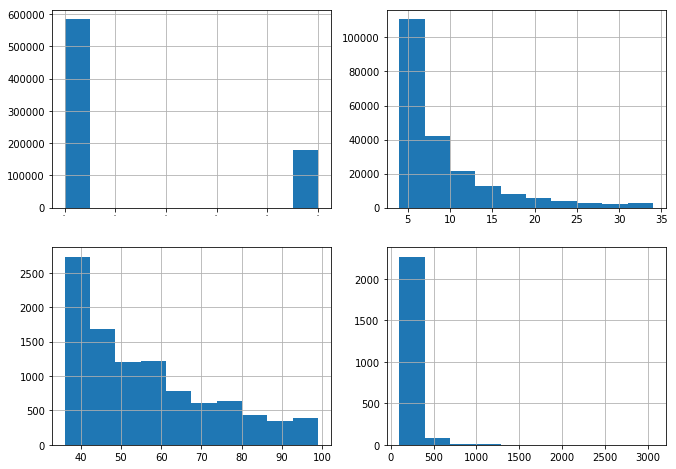

In [96]:
# number of users by review count
usr_rev_count = rest_df.groupby('user_id')['review_id'].count()
print(usr_rev_count.describe())
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(11,8)
usr_rev_count[usr_rev_count < 3].hist(ax=axes[0,0],xlabelsize=2)
usr_rev_count[(usr_rev_count > 3) & (usr_rev_count < 35)].hist(ax=axes[0,1])
usr_rev_count[(usr_rev_count > 35) & (usr_rev_count < 100)].hist(ax=axes[1,0])
usr_rev_count[(usr_rev_count > 100)].hist(ax=axes[1,1])

In [97]:
rest_df['usr_rev_count'] = rest_df.groupby('user_id')['review_id'].transform('count')
rest_df_smpl = rest_df[(rest_df.usr_rev_count > 10) & (rest_df.usr_rev_count < 20)]

In [98]:
rest_df_smpl['stars_delta'] = rest_df_smpl.stars_rev - rest_df_smpl.stars_rest
rest_df_smpl['avg_star_delta'] = rest_df_smpl.groupby(['user_id'])['stars_delta'].transform('mean')

C:\Users\dorse\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dorse\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


       avg_star_delta
count    35051.000000
mean         0.019316
std          0.542515
min         -2.666667
25%         -0.291667
50%          0.062500
75%          0.384615
max          1.833333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B074CAC710>]],
      dtype=object)

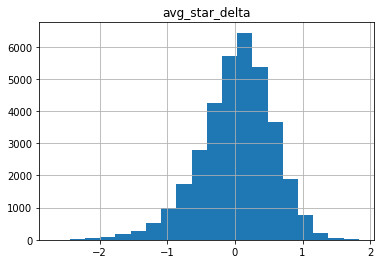

In [99]:
# distribution of users average star delta
usr_deltas = rest_df_smpl[['user_id','avg_star_delta']].drop_duplicates()
print(usr_deltas.describe()) # .54/-.54 std to be used as easy/med/hard thresholds
usr_deltas.hist(bins=20, xlabelsize=10)

In [100]:
# number of easy, med, hard reviews
print(len(rest_df_smpl[rest_df_smpl.avg_star_delta < -0.5]))
print(len(rest_df_smpl[(rest_df_smpl.avg_star_delta > -0.5) & (rest_df_smpl.avg_star_delta < 0.5)]))
print(len(rest_df_smpl[rest_df_smpl.avg_star_delta > 0.5]))

73403
319339
81423


In [101]:
df_by_usr = rest_df_smpl.groupby(['user_id', 'avg_star_delta'])['text'].sum().reset_index(name='text_agg')
df_by_usr['reviewer_label'] = pd.cut(df_by_usr['avg_star_delta'], bins=[-5,-0.5,.5,5], include_lowest=False, labels=['hard', 'med', 'easy'])

In [102]:
# number of easy, med, hard reviewers
hard = sum(df_by_usr['reviewer_label'] == 'easy')
med = sum(df_by_usr['reviewer_label'] == 'med')
easy = sum(df_by_usr['reviewer_label'] == 'hard')
print(hard)
print(med)
print(easy)
print(med/len(df_by_usr))

5910
23403
5738
0.6676842315483154


In [103]:
# distribution of review length
rest_df_smpl['rev_len'] = rest_df_smpl.text.apply(lambda x: len(x))

C:\Users\dorse\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count    489729.000000
mean        558.578048
std         506.893250
min           1.000000
25%         231.000000
50%         402.000000
75%         709.000000
max        5000.000000
Name: rev_len, dtype: float64


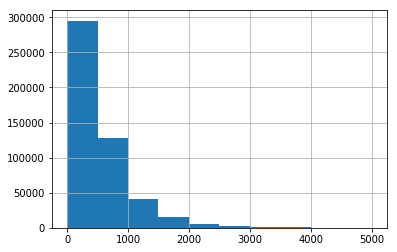

In [104]:
# distribution of individual reviews by string length (# of characters)
print(rest_df_smpl.rev_len.describe())
rest_df_smpl.rev_len.hist()

## Process text data

In [105]:
def normalize(text):
    """
    Normalize text as follows: lowercase, strip punctuation,
    remove stop words, drop words of length < 3, lemmatize words.
    """
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)  # delete stuff but leave at least a space to avoid clumping together
    words = nopunct.split(" ")
    lemm = WordNetLemmatizer()
    words = [lemm.lemmatize(w.lower()) for w in words if len(w) > 2 and w.lower() not in ENGLISH_STOP_WORDS]
    
    return ' '.join(words)

In [106]:
df_by_usr.text_agg = df_by_usr.text_agg.apply(lambda x: normalize(x))

In [107]:
# Compare lengths of aggregated text pre and post normalizing
unproc_text = rest_df_smpl.groupby(['user_id', 'avg_star_delta'])['text'].sum().reset_index(name='text_agg')
print(unproc_text.text_agg.apply(lambda x: len(x)).describe()) # previous lengths of aggregated review text
df_by_usr.text_agg.apply(lambda x: len(x)).describe() # lengths of aggregated review text post-processing

count    35051.000000
mean      7804.395566
std       5053.949112
min        836.000000
25%       4371.000000
50%       6452.000000
75%       9774.500000
max      76422.000000
Name: text_agg, dtype: float64


count    35051.000000
mean      4254.658498
std       2738.314453
min         14.000000
25%       2414.000000
50%       3512.000000
75%       5279.000000
max      43510.000000
Name: text_agg, dtype: float64

## Write tidy data back to json file

In [108]:
with open('df_by_usr.json', 'w', encoding='UTF-8') as f:
    f.write(df_by_usr.to_json(orient='records', lines=True))

## Test reading back in tidy data

In [ ]:
with open('df_by_usr.json', 'r', encoding='UTF-8') as f:
    data = f.readlines()
    df_by_usr_data = list(map(json.loads, data))
    
df_by_usr = pd.DataFrame(df_by_usr_data)

In [ ]:
hard = sum(df_by_usr_r['reviewer_label'] == 'easy')
med = sum(df_by_usr_r['reviewer_label'] == 'med')
easy = sum(df_by_usr_r['reviewer_label'] == 'hard')
print(hard)
print(med)
print(easy)
print(med/len(df_by_usr_r))
df_by_usr_r.describe()